# Imports

In [1]:
import tensorflow as tf
from tensorflow.keras import layers

import kagglehub
import os

from PIL import Image
import matplotlib.pyplot as plt

import numpy as np
import time

from IPython import display
from tqdm import tqdm

# Downloading Data from keaggle

In [2]:
path = kagglehub.dataset_download("tawsifurrahman/covid19-radiography-database")
# print("Path to dataset files:", path)

## Loading a test image

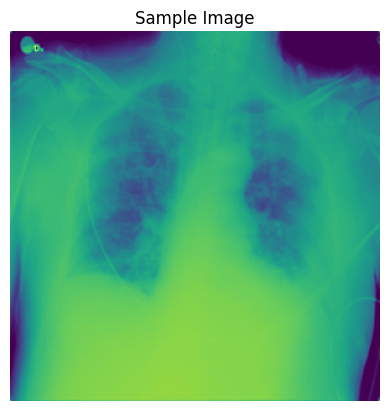

In [3]:
image_folder = os.path.join(path, 'COVID-19_Radiography_Dataset/COVID/images/') 

image_filename = os.listdir(image_folder)[0]  
image_path = os.path.join(image_folder, image_filename)

image = Image.open(image_path)

width, height = image.size
mode = image.mode 

plt.imshow(image)
plt.title("Sample Image")
plt.axis("off")
plt.show()

## Getting the number of files in each directory

In [23]:
def count_images_in_folder(folder_path):
    return len([file for file in os.listdir(folder_path) if file.lower().endswith(('.png', '.jpg', '.jpeg'))])

total_images = 0
for root, dirs, files in os.walk(path):
    num_images = count_images_in_folder(root)
    total_images += num_images
    if num_images > 0:
        print(f"Found {num_images} images")
        # print(f"Found {num_images} images in {root}")

print(f"Total number of images in the dataset: {total_images}")

Found 1345 images
Found 1345 images
Found 6012 images
Found 6012 images
Found 10192 images
Found 10192 images
Found 3616 images
Found 3616 images
Total number of images in the dataset: 42330


## Load and reshape all the images

In [5]:
PIC_DIR = f'(your_path)/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5/COVID-19_Radiography_Dataset/COVID/images/'
IMAGES_COUNT = 3616

images = []
for pic_file in tqdm(os.listdir(PIC_DIR)[:IMAGES_COUNT]):
    pic = Image.open(os.path.join(PIC_DIR, pic_file))
    pic = pic.resize((64, 64))
    images.append(np.uint8(pic))



100%|██████████| 3616/3616 [00:05<00:00, 614.86it/s]


## Normalizing and reshape

In [6]:
images = np.array(images) / 255
images = images.reshape(images.shape[0], 64, 64, 1).astype('float32')

images.shape

(3616, 64, 64, 1)

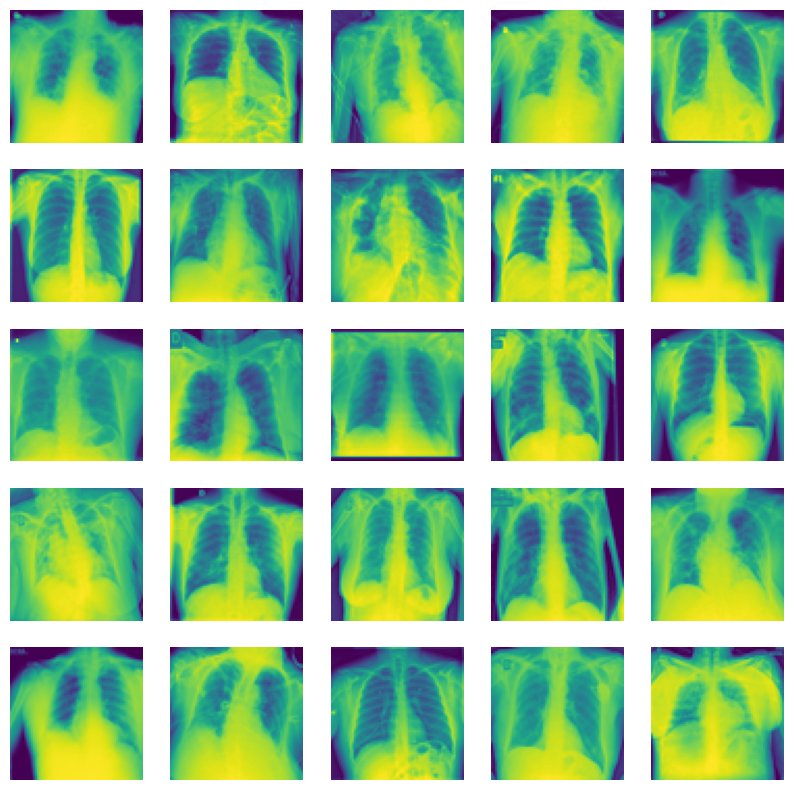

In [7]:
plt.figure(1, figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

# Model

## Generator

In [8]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(16*16*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())                 
    model.add(layers.LeakyReLU())                          
                                                       
    model.add(layers.Reshape((16, 16, 256)))
    assert model.output_shape == (None, 16, 16, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 1)

    return model

/Users/mateusrico/data-science/venv 15-48-07-293/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


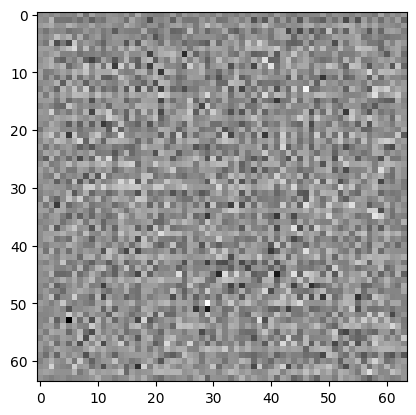

In [9]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [10]:
generated_image.shape

TensorShape([1, 64, 64, 1])

## Discriminator

In [11]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, 1])) 
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [12]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)

print(decision)

/Users/mateusrico/data-science/venv 15-48-07-293/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


tf.Tensor([[-0.00106156]], shape=(1, 1), dtype=float32)


## GAN

In [13]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [14]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [15]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [16]:
EPOCHS = 10
BUFFER_SIZE = 60000
BATCH_SIZE = 256

noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [17]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [18]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [19]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='gray')
      plt.axis('off')

  plt.savefig('xray_images/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [20]:
train_dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

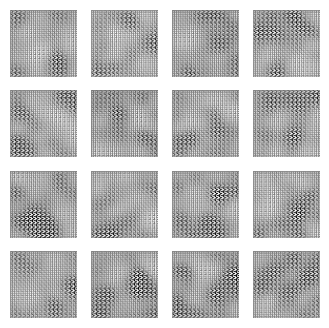

In [21]:
train(train_dataset, EPOCHS)

### save model

In [22]:
# generator.save('saved_model/generator_v0.keras')
# discriminator.save('saved_model/discriminator_v0.keras')